In [1]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from scipy.sparse.linalg import svds
import scipy.sparse as sp
from numpy.linalg import svd

In [2]:
# Load the data and create the matrices

data_dict = io.loadmat('usps.mat')

train_patterns = data_dict['train_patterns']
train_labels = data_dict['train_labels']

test_patterns = data_dict['test_patterns']
test_labels = data_dict['test_labels']

2.3a)

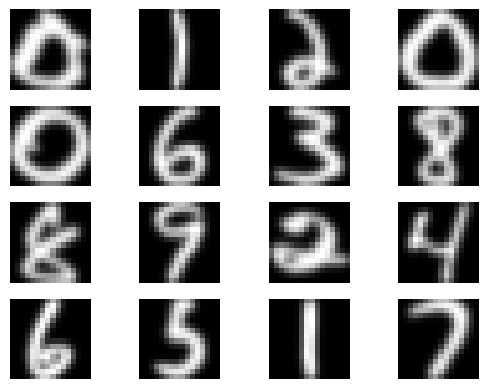

In [3]:
# Display the original figures

fig, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        col = i * 4 + j + 1
        axes[i, j].imshow(np.reshape(train_patterns[:, col], (16, 16)), cmap = 'grey')
        axes[i, j].axis('off')
plt.show()

2.3b) Compute the mean pixel data for each digit (0, 1, ..., 9)

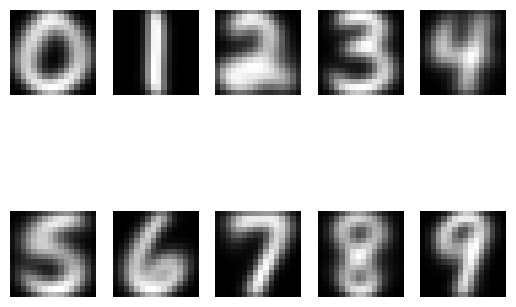

(256, 10)

In [4]:
# Make train_aves of size 256x10

train_aves = []
fig, axes = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        digit = 5*i + j
        digit_mean = np.mean(train_patterns[:,train_labels[digit,:]==1], axis=1)

        # Reshape digit_mean to have 1 column
        digit_mean = np.reshape(digit_mean, (256, 1))
        train_aves.append(digit_mean)
        
        # Reshape digit_mean for image
        digit_img = np.reshape(digit_mean, (16, 16))
        axes[i, j].imshow(digit_img, cmap = 'grey')
        axes[i, j].axis('off')
plt.show()
train_aves = np.concatenate(train_aves, axis=1)
train_aves.shape

Basically, what I did in the above step was look in the train_labels matrix and find the indexes that pair with number 0, 1, ..., 9 and use those indices to find the mean digit data in the train_patterns matrix. In simple terms, find the mean pixels for each number and show the images.

In [6]:
# Calculating the condition number k(A) of the mean digit pixel data matrix train_aves
# Large k(A) signifies linear system is not stable, solution Ax = b has large error and A is close to linear dependence
# Low k(A) signifies linear system is stable, Ax= b has small error, and A has distinct column vectors, not close to linear dependence.

tmp, train_aves_sigma, tmp2 = np.linalg.svd(train_aves)

# Calculate the k(A) with sigma1 / sigma10:
print(train_aves_sigma[0] / train_aves_sigma[-1])
train_aves_sigma

17.646001908077142


array([30.45664032,  8.769182  ,  7.05170477,  5.24734103,  4.56601767,
        4.31044144,  3.54615739,  3.00793607,  2.12147029,  1.72597966])

The condition number is high here, signifying that the matrix is ill conditioned, and may have nearly linearly dependent columns 

2.3c) Conduct the classification experiment

2.3c.1) Create a matrix test_classif (10x4649) with the Euclidean distance between each image in the test_patterns and each mean digit in train_aves

In [7]:
test_classif = []

for i in range(4649):  # 4649 cols in test_patterns
    test_classif_col = []
    for j in range(10):  # 10 cols in train_aves.T
        diff = test_patterns[:, i] - train_aves[:, j]
        two_norm = np.linalg.norm(diff, ord=2)
        test_classif_col.append(two_norm*two_norm)
    test_classif_col = np.array(test_classif_col)
    test_classif_col = np.reshape(test_classif_col, (10, 1))
    test_classif.append(test_classif_col)

test_classif = np.concatenate(test_classif, axis=1)
test_classif.shape

(10, 4649)

Basically this step in english, I found the 2 norm distance between each column (image pixel data) in test_pattern with each column in train_aves (the mean pixel data for 0, 1, ..., 9) and appended that 2 norm to each row of each column of test_classif.

test_classif is now a 10x4649 matrix with each tc[1, 1] being the 2-norm difference between column 1 in test_patterns and column 1 in train_aves.
tc[1, 1] represents test_pattern's first pixel image data with mean pixel data of digit 0.
tc[1, 2] represents test_pattern's first pixel image data with mean pixel data of digit 1. etc

2.3c.2) Compute the classification results by finding the smallest 2-norm in test_classif

In [8]:
test_classif_res = []

for i in range(4649):  # 4649 cols in test_classif
    index = np.argmin(test_classif[:, i])
    test_classif_res.append(index)

test_classif_res = np.reshape(test_classif_res, (1, 4649))
test_classif_res.shape

(1, 4649)

In this step we found the smallest 2-norm in each column of test_classif, and used that index as determining what the pixels in test_patterns most closely relate to. test_classif_res is a 1x4649 matrix, of the digits that the 2-norm thinks is the most likely digit, based off the difference.

For example: test_classif_res[0], is the digit that we think test_patterns's first column is, based off 2-norm.

2.3c.3) Compute the 10x10 confusion matrix with the ratio of test_patterns with the correct predicted label.

In [51]:
# for each valid digit (0, 1, ..., 9) count how many of those digits we correctly guessed in test_classif_res and turn it into a 
# vector with the frequency of each digit at it's column location in v.
test_confusion = []

for k in range(10):  # 10 because 10 total digits (0, 1, ..., 9)
    
    tmp = test_classif_res[0, np.where(test_labels[k, :] == 1)[0]]
    tmp_flat = tmp.flatten()
    unique_elements, counts = np.unique(tmp_flat, return_counts=True)

    # Add the frequencies of each digit into the row_k
    row_k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for val, count in zip(unique_elements, counts):
        row_k[val] = count
    test_confusion.append(row_k)

test_confusion = np.array(test_confusion)
print(test_confusion.shape)
test_confusion

(10, 10)


array([[656,   1,   3,   4,  10,  19,  73,   2,  17,   1],
       [  0, 644,   0,   1,   0,   0,   1,   0,   1,   0],
       [ 14,   4, 362,  13,  25,   5,   4,   9,  18,   0],
       [  1,   3,   4, 368,   1,  17,   0,   3,  14,   7],
       [  3,  16,   6,   0, 363,   1,   8,   1,   5,  40],
       [ 13,   3,   3,  20,  14, 271,   9,   0,  16,   6],
       [ 23,  11,  13,   0,   9,   3, 354,   0,   1,   0],
       [  0,   5,   1,   0,   7,   1,   0, 351,   3,  34],
       [  9,  19,   5,  12,   6,   6,   0,   1, 253,  20],
       [  1,  15,   0,   1,  39,   2,   0,  24,   3, 314]], dtype=int64)

In [10]:
# No SVD approximation success rate:

correct = np.trace(test_confusion)
total = np.sum(test_confusion)
correct / total

0.8466336846633684

In this step we found which column indexes have which digits in them, then used those indexes to look in our test_classif_res object to see (for example) if our 1's actually had 1's in them. We then counted the number of each element into a vector row_k then turned that into a matrix test_confusion

2.3d.1) Compute the rank k SVD of the train_patterns for each digit (0, 1, ..., 9), then put the left singular vectors into a tensor of size 256 x k x 10

In [11]:
# start with k = 10
k = 10
train_u = np.zeros((256, k, 10))

for j in range(10):
    train_u[:,:,j], tmp, tmp2 = svds(train_patterns[:,train_labels[j,:] == 1], k)

In [11]:
train_u.shape

(256, 10, 10)

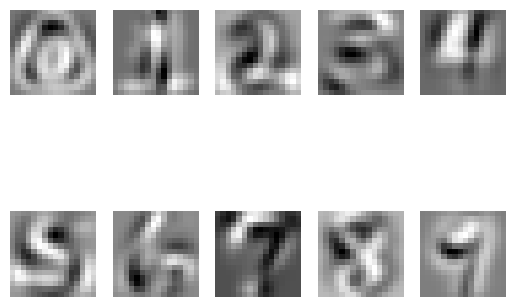

In [12]:
# Visualize the left singular vectors:

fig, axes = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        digit = 5*i + j
        left_sing_vector = np.reshape(train_u[:, j, digit], (16, 16))
        axes[i, j].imshow(left_sing_vector, cmap = 'grey')
        axes[i, j].axis('off')
plt.show()

In this step, we created a tensor matrix train_u that has dimensions 256xkx10, where k is the A_k SVD approximation of all the train patterns, with the k left singular vectors. 

2.3d.2) Compute the expansion coefficients of each test digit. Compute k x 10 numbers for each image and put the results in the 3D tensor array test_svd of size k x 4649 x 10.

In [13]:
test_svd = np.zeros((k, 4649, 10))

for j in range(10):
    test_svd[:, :, j] = train_u[:, :, j].T @ test_patterns

test_svd.shape

(10, 4649, 10)

2.3d.3) Compute the error between each original test digit image and its rank k approximation.

In [14]:
# Compute the approximations:
rank_k_approx = np.zeros((256, 4649, 10))

for j in range(10):
    rank_k_approx[:, :, j] = train_u[:, :, j] @ test_svd[:, :, j]

rank_k_approx.shape

(256, 4649, 10)

In [15]:
error_data = []
indices = []

for i in range(10):
    error_data.append(np.linalg.norm(rank_k_approx[:, :, i] - test_patterns, ord='fro'))
    indices.append(i)

pd.DataFrame({'Digit': indices,
              'Frobenius Norm Error': error_data})

,Digit,Frobenius Norm Error
0,0,416.344496
1,1,427.103242
2,2,413.074698
3,3,424.663474
4,4,426.979200
5,5,430.343440
6,6,430.840114
7,7,429.525212
8,8,413.580089
9,9,440.114515


In [16]:
test_svdres = []

for i in range(4649):  # 4649 train_patterns is 256x4649
    original = test_patterns[:, i]
    row = []
    for j in range(10):
        rank_k_approx_col = rank_k_approx[:, i, j]
        diff = np.linalg.norm(original - rank_k_approx_col, ord=2)
        row.append(diff)
    test_svdres.append(row)

test_svdres = np.column_stack(test_svdres)
test_svdres.shape

(10, 4649)

2.3d.4) Create a function usps_svd_classification that compares the overall classification rate for k = 1:20.

In [17]:
def usps_svd_classification(train_patterns, test_patterns, train_labels, test_labels, k) -> int:
    """
    This function approximates the pixel data in train_patterns using different k components in the SVD,
    then returns the overall predicted classification rate and predicted labels for each digit in test_patterns

    INPUT:

    - train_patterns: A mxn matrix with n pixel data vectors, describing handwritten digits (0, 1, ..., 9). This will train the prediction model.
    - test_patterns: A mxn matrix with n pixel data vectors that we will utilize to quantify the success of our prediction model.
    - train_label: A 10xn matrix with each n vector consisting of nine -1's and one 1 at the index where the train_pattern pixel data digit corresponds to.
    - test_label: A 10xn matrix with each n vector consisting of nine -1's and one 1 at the index where the test_pattern pixel data digit corresponds to.
    - k: the starting number of components in the SVD

    OUTPUT:

    - rate: the overall classification rate of our predictive model on the test_patterns
    - test_predict: the predicted digit labels for the test_patterns
    """
    nrows = train_patterns.shape[0]
    ncols = train_patterns.shape[1]

    # Create a 3D matrix for each U in the SVD decomposition of rank k for digits (0, 1, ..., 9)
    train_u = np.zeros((nrows, k, 10))

    # Create a 3D matrix for the expansion coefficients for each digit
    test_svd = np.zeros((k, ncols, 10))

    # Create a 3D matrix for the predicted digits, based on 2-norm
    rank_k_approx = np.zeros((nrows, ncols, 10))
    
    for j in range(10):

        # Each sheet of train_u are the left singular values of the rank k SVD
        train_u[:,:,j], tmp, tmp2 = svds(train_patterns[:,train_labels[j,:] == 1], k)

        # Each sheet of test_svd are the expansion coefficients in a = U.T @ x
        test_svd[:, :, j] = train_u[:, :, j].T @ test_patterns

        # Our approximation for each digit using the k-rank SVD, left singular vectors, and expansion coefficients
        rank_k_approx[:, :, j] = train_u[:, :, j] @ test_svd[:, :, j]

    test_svdres = []
    for i in range(ncols):  
        original = test_patterns[:, i]
        row = []
        for j in range(10):
            rank_k_approx_col = rank_k_approx[:, i, j]
            # Quantify the difference between our prediction and the original photo pixel data, lower 2-norm the better
            diff = np.linalg.norm(original - rank_k_approx_col, ord=2)
            row.append(diff)
        test_svdres.append(row)
    test_svdres = np.column_stack(test_svdres)

    test_svd_pred = []
    for i in range(ncols):
        # Find the index in which test_svdres has the lowest 2-norm
        index = np.argmin(test_svdres[:, i])
        test_svd_pred.append(index)
    test_svd_pred = np.reshape(test_svd_pred, (1, ncols))

    test_svd_confusion = []
    for k in range(10):
        # Find the lowest 2-norm difference between the original pixel data and our approximation.
        tmp = test_svd_pred[0, np.where(test_labels[k, :] == 1)[0]]
        tmp_flat = tmp.flatten()
        unique_elements, counts = np.unique(tmp_flat, return_counts=True)
        # Add the frequencies of each digit into the row_k
        row_k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for val, count in zip(unique_elements, counts):
            row_k[val] = count
        test_svd_confusion.append(row_k)
    test_svd_confusion = np.array(test_svd_confusion)
    
    correct = np.trace(test_svd_confusion)
    total = np.sum(test_svd_confusion)
    classif_rate = correct / total
    return classif_rate

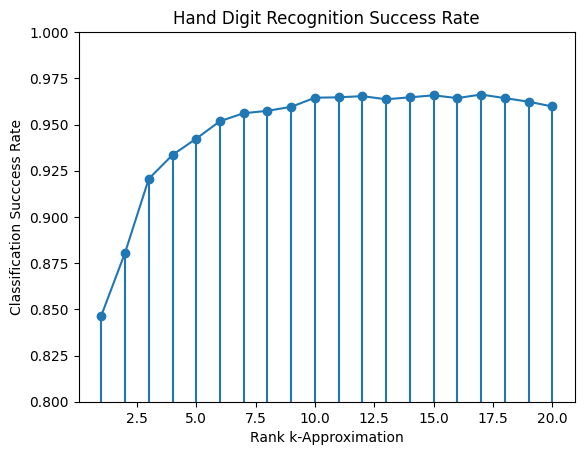

In [18]:
classif_rates = []
k_s = []

for k in range(1, 21):
    classif_rate = usps_svd_classification(train_patterns, test_patterns, train_labels, test_labels, k)
    k_s.append(k)
    classif_rates.append(classif_rate)

plt.stem(k_s, classif_rates)
plt.plot(k_s, classif_rates)
plt.ylim(0.8, 1.0)
plt.title('Hand Digit Recognition Success Rate')
plt.xlabel('Rank k-Approximation')
plt.ylabel('Classification Succcess Rate')
plt.show()

In [19]:
max_val, max_index = max((val, index) for index, val in enumerate(classif_rates))
print('The maximum classification rate is', max_val, 'at k =', max_index+1)

The maximum classification rate is 0.9662292966229297 at k = 17


2.3d.5) Compute the confusion matrix and overall classification rate using the best k approximation via SVD. 

In [20]:
# Using k=17, the maximum classification rate:

best_k = 17
best_train_u = np.zeros((256, best_k, 10))

for j in range(10):
    best_train_u[:,:,j], tmp, tmp2 = svds(train_patterns[:,train_labels[j,:] == 1], best_k)

In [21]:
best_test_svd = np.zeros((best_k, 4649, 10))

for j in range(10):
    best_test_svd[:, :, j] = best_train_u[:, :, j].T @ test_patterns

In [22]:
# Compute the approximations:
best_rank_k_approx = np.zeros((256, 4649, 10))

for j in range(10):
    best_rank_k_approx[:, :, j] = best_train_u[:, :, j] @ best_test_svd[:, :, j]

In [23]:
error_data = []
indices = []

for i in range(10):
    error_data.append(np.linalg.norm(best_rank_k_approx[:, :, i] - test_patterns, ord='fro'))
    indices.append(i)

pd.DataFrame({'Digit': indices,
              'Frobenius Norm Error': error_data})

,Digit,Frobenius Norm Error
0,0,333.178143
1,1,376.798858
2,2,357.975033
3,3,342.574259
4,4,370.491506
5,5,326.749094
6,6,351.284773
7,7,372.313935
8,8,340.563460
9,9,372.307304


In [24]:
best_test_svdres = []

for i in range(4649):  # 4649 train_patterns is 256x4649
    original = test_patterns[:, i]
    row = []
    for j in range(10):
        best_rank_k_approx_col = best_rank_k_approx[:, i, j]
        diff = np.linalg.norm(original - best_rank_k_approx_col, ord=2)
        row.append(diff)
    best_test_svdres.append(row)

best_test_svdres = np.column_stack(best_test_svdres)

In [25]:
best_test_svd_pred = []

for i in range(4649):  # 4649 cols in test_svdres
    index = np.argmin(best_test_svdres[:, i])
    best_test_svd_pred.append(index)

best_test_svd_pred = np.reshape(best_test_svd_pred, (1, 4649))

In [26]:
# for each valid digit (0, 1, ..., 9) count how many of those digits we correctly guessed in test_classif_res and turn it into a 
# vector with the frequency of each digit at it's column location in v.
best_test_svd_confusion = []

for k in range(10):  # 10 because 10 total digits (0, 1, ..., 9)
    
    tmp = best_test_svd_pred[0, np.where(test_labels[k, :] == 1)[0]]
    tmp_flat = tmp.flatten()
    unique_elements, counts = np.unique(tmp_flat, return_counts=True)

    # Add the frequencies of each digit into the row_k
    row_k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for val, count in zip(unique_elements, counts):
        row_k[val] = count
    best_test_svd_confusion.append(row_k)

best_test_svd_confusion = np.array(best_test_svd_confusion)
best_test_svd_confusion

array([[772,   2,   1,   3,   1,   1,   2,   1,   3,   0],
       [  0, 646,   0,   0,   0,   0,   0,   0,   0,   1],
       [  3,   6, 431,   6,   0,   3,   1,   2,   2,   0],
       [  1,   1,   4, 401,   0,   7,   0,   0,   4,   0],
       [  2,   8,   1,   0, 424,   1,   1,   5,   0,   1],
       [  2,   0,   0,   5,   2, 335,   7,   1,   1,   2],
       [  6,   4,   0,   0,   2,   3, 399,   0,   0,   0],
       [  0,   2,   0,   0,   2,   0,   0, 387,   0,  11],
       [  2,   9,   1,   5,   1,   1,   0,   0, 309,   3],
       [  0,   5,   0,   1,   0,   0,   0,   4,   1, 388]], dtype=int64)

In [27]:
correct = np.trace(best_test_svd_confusion)
total = np.sum(best_test_svd_confusion)

correct / total

0.9662292966229297

In [28]:
# Testing with data from sci-kit
# usps_svd_classification(train_patterns, test_patterns, train_labels, test_labels, k)

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [29]:
digits = datasets.load_digits()

In [52]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [31]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

In [33]:
# Reformat objects for function to read

x_train_new = x_train.T
x_test_new = x_test.T

# Remove the last column because x_train and x_test have a different amount of cols
x_test_new = x_test_new[:, :-1]

In [34]:
y_train_new = -1 * np.ones((10, y_train.shape[0]))
for index, i in enumerate(y_train):
    y_train_new[i , index] = 1

y_train_new.shape

(10, 898)

In [35]:
y_test_new = -1 * np.ones((10, y_test.shape[0]))
for index, i in enumerate(y_test):
    y_test_new[i , index] = 1

# Remove 1 column so that our x and y datasets have the same number of cols
y_test_new = y_test_new[:, :-1]
y_test_new.shape

(10, 898)

In [36]:
# usps_svd_classification(train_patterns, test_patterns, train_labels, test_labels, k)
usps_svd_classification(x_train_new, x_test_new, y_train_new, y_test_new, k=10)

0.9565701559020044

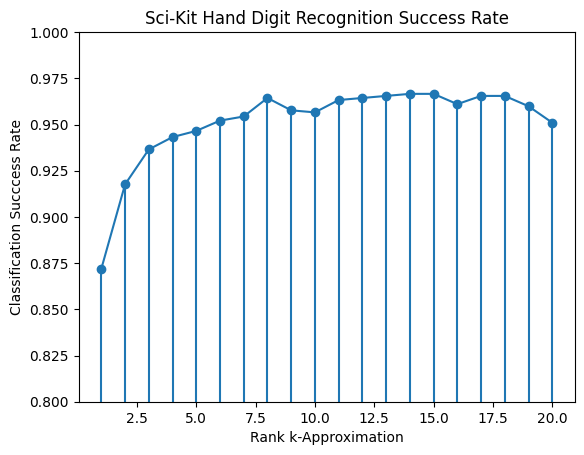

In [37]:
classif_rates = []
k_s = []

for k in range(1, 21):
    classif_rate = usps_svd_classification(x_train_new, x_test_new, y_train_new, y_test_new, k)
    k_s.append(k)
    classif_rates.append(classif_rate)

plt.stem(k_s, classif_rates)
plt.plot(k_s, classif_rates)
plt.ylim(0.8, 1.0)
plt.title('Sci-Kit Hand Digit Recognition Success Rate')
plt.xlabel('Rank k-Approximation')
plt.ylabel('Classification Succcess Rate')
plt.show()

In [38]:
max_val, max_index = max((val, index) for index, val in enumerate(classif_rates))
print('The maximum classification rate is', max_val, 'at k =', max_index+1)

The maximum classification rate is 0.9665924276169265 at k = 15


In [54]:
# Using k=17, the maximum classification rate:

sci_k = 15
sci_train_u = np.zeros((64, sci_k, 10))

for j in range(10):
    sci_train_u[:,:,j], tmp, tmp2 = svds(x_train_new[:,y_train_new[j,:] == 1], sci_k)

In [55]:
sci_test_svd = np.zeros((sci_k, 898, 10))

for j in range(10):
    sci_test_svd[:, :, j] = sci_train_u[:, :, j].T @ x_test_new

In [56]:
# Compute the approximations:
sci_rank_k_approx = np.zeros((64, 898, 10))

for j in range(10):
    sci_rank_k_approx[:, :, j] = sci_train_u[:, :, j] @ sci_test_svd[:, :, j]

In [57]:
sci_test_svdres = []

for i in range(898):  # 898 train_patterns is 256x4649
    original = x_test_new[:, i]
    row = []
    for j in range(10):
        sci_rank_k_approx_col = sci_rank_k_approx[:, i, j]
        diff = np.linalg.norm(original - sci_rank_k_approx_col, ord=2)
        row.append(diff)
    sci_test_svdres.append(row)

sci_test_svdres = np.column_stack(sci_test_svdres)

In [58]:
sci_test_svd_pred = []

for i in range(898):  # 898 cols in sci_test_svdres
    index = np.argmin(sci_test_svdres[:, i])
    sci_test_svd_pred.append(index)

sci_test_svd_pred = np.reshape(sci_test_svd_pred, (1, 898))

In [59]:
# for each valid digit (0, 1, ..., 9) count how many of those digits we correctly guessed in test_classif_res and turn it into a 
# vector with the frequency of each digit at it's column location in v.
sci_test_svd_confusion = []

for k in range(10):  # 10 because 10 total digits (0, 1, ..., 9)
    
    tmp = sci_test_svd_pred[0, np.where(y_test_new[k, :] == 1)[0]]
    tmp_flat = tmp.flatten()
    unique_elements, counts = np.unique(tmp_flat, return_counts=True)

    # Add the frequencies of each digit into the row_k
    row_k = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for val, count in zip(unique_elements, counts):
        row_k[val] = count
    sci_test_svd_confusion.append(row_k)

sci_test_svd_confusion = np.array(sci_test_svd_confusion)
sci_test_svd_confusion

array([[88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 89,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 86,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 87,  0,  0,  0,  1,  2,  0],
       [ 1,  0,  0,  0, 85,  0,  0,  2,  0,  4],
       [ 0,  0,  0,  0,  0, 86,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0, 91,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 89,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0, 79,  0],
       [ 0,  0,  0,  3,  0,  1,  0,  0,  0, 88]], dtype=int64)

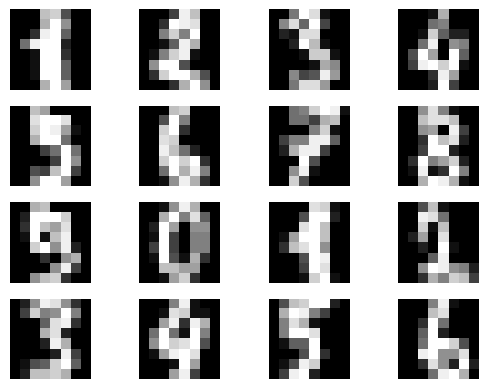

In [48]:
# Display the original figures in Sci-Kit

fig, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        col = i * 4 + j + 1
        axes[i, j].imshow(np.reshape(x_train_new[:, col], (8, 8)), cmap = 'grey')
        axes[i, j].axis('off')
plt.show()

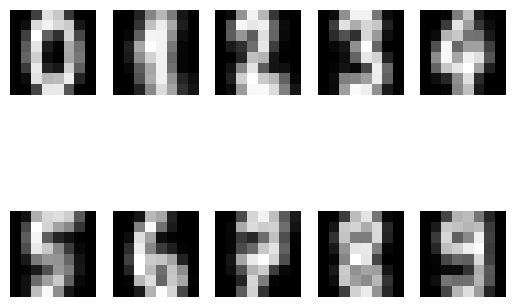

(64, 10)

In [50]:
# Make train_aves_x from the Sci-Kit data

train_aves_x = []
fig, axes = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        digit = 5*i + j
        digit_mean = np.mean(x_train_new[:,y_train_new[digit,:]==1], axis=1)

        # Reshape digit_mean to have 1 column
        digit_mean = np.reshape(digit_mean, (64, 1))
        train_aves_x.append(digit_mean)
        
        # Reshape digit_mean for image
        digit_img = np.reshape(digit_mean, (8, 8))
        axes[i, j].imshow(digit_img, cmap = 'grey')
        axes[i, j].axis('off')
plt.show()
train_aves_x = np.concatenate(train_aves_x, axis=1)
train_aves_x.shape

In [39]:
# Testing random things

n_samples

1797

In [44]:
print(x_train_new.shape)
x_train_new

(64, 898)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 5.,  0.,  0., ...,  2., 12.,  0.],
       ...,
       [ 0., 10., 16., ..., 14.,  0.,  3.],
       [ 0.,  0.,  9., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [45]:
print(x_test_new.shape)
x_test_new

(64, 898)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  6.,  0., ...,  6.,  1.,  2.],
       ...,
       [12.,  6.,  2., ...,  6.,  6., 12.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [46]:
print(y_train_new.shape)
y_train_new

(10, 898)


array([[ 1., -1., -1., ..., -1., -1., -1.],
       [-1.,  1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1., -1., -1.]])

In [47]:
print(y_test_new.shape)
y_test_new

(10, 898)


array([[-1., -1., -1., ...,  1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1., -1.,  1.]])